In [1]:
import os
import tqdm
import torch
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

import fbbo

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
save_images = True

# default settings
plt.rcParams["figure.dpi"] = 200  # 200 at (6, 3) is size (1200 x 600 pixels)
plt.rcParams["figure.figsize"] = [6, 3]
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.transparent"] = True

if save_images:
    # configure matplotlib to use latex so we're able to use the libertine font
    plt.rcParams["text.usetex"] = True
    plt.rcParams[
        "text.latex.preamble"
    ] = r"""
\usepackage{libertine}
\usepackage[libertine]{newtxmath}
\usepackage{sfmath}
\usepackage[T1]{fontenc}
"""

    import matplotlib

    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42
    matplotlib.rcParams["backend"] = "pdf"
else:
    plt.rcParams["text.usetex"] = False

In [12]:
# problem settings
budget = 200
n_runs = 51

# functions we optimised and their parameters
problems = {
    "Branin": {"fname": "Branin", "params": {}},
    "Eggholder": {"fname": "Eggholder", "params": {}},
    "GoldsteinPrice": {"fname": "GoldsteinPrice", "params": {}},
    "SixHumpCamel": {"fname": "SixHumpCamel", "params": {}},
    "Hartmann3": {"fname": "Hartmann3", "params": {}},
    "Hartmann6": {"fname": "Hartmann6", "params": {}},
    "Ackley5": {"fname": "Ackley", "params": {"d": 5}},
    "Ackley10": {"fname": "Ackley", "params": {"d": 10}},
    "Michalewicz5": {"fname": "Michalewicz", "params": {"d": 5}},
    "Michalewicz10": {"fname": "Michalewicz", "params": {"d": 10}},
    "Rosenbrock7": {"fname": "Rosenbrock", "params": {"d": 7}},
    "Rosenbrock10": {"fname": "Rosenbrock", "params": {"d": 10}},
    "StyblinskiTang5": {"fname": "StyblinskiTang", "params": {"d": 5}},
    "StyblinskiTang7": {"fname": "StyblinskiTang", "params": {"d": 7}},
    "StyblinskiTang10": {"fname": "StyblinskiTang", "params": {"d": 10}},
}

# experiment names and corresponding directories
problem_sets = {
    "noise-free": {"papername": "noise-free", "noise_level": 0.0},
    "noise=0.05": {"papername": r"$\sigma_n = 0.05$", "noise_level": 0.05},
    "noise=0.1": {"papername": r"$\sigma_n = 0.1$", "noise_level": 0.1},
    "noise=0.2": {"papername": r"$\sigma_n = 0.2$", "noise_level": 0.2},
}

# 'method' names and the version we use in the paper
methods = {
    "map": {"papername": "MAP", "color": "tab:blue"},
    "mcmc_pm3": {"papername": "MCMC", "color": "tab:red"},
    "vimf": {"papername": "MFVI", "color": "tab:orange"},
    "vifr": {"papername": "FRVI", "color": "tab:green"},
}

# acquisition functions and their names for the paper
acq_funcs = {
    "ei": "EI",
    "ucb": "UCB",
    # "egreedy": r"$\epsilon$-greedy"
}

# with and without ARD
use_ard = [False, True]

### Load all results

In [16]:
results = {}

for problem_set in tqdm.auto.tqdm(problem_sets):

    results[problem_set] = fbbo.results.load_results(
        problems=problems,
        methods=methods,
        acq_funcs=acq_funcs,
        n_runs=n_runs,
        budget=budget,
        use_ard=use_ard,
        noise_level=problem_sets[problem_set]["noise_level"],
    )

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

## Process tables

In [17]:
# load table data
table_data = {}

with tqdm.auto.tqdm(total=len(problem_sets) * len(use_ard)) as pbar:
    for problem_set in problem_sets:
        table_data[problem_set] = {}

        for ard in use_ard:
            table_data[problem_set][ard] = fbbo.results.create_table_data(
                results=results[problem_set],
                problems=problems,
                ard=ard,
                acq_funcs=acq_funcs,
                methods=methods,
                n_runs=n_runs,
                time=-1,
            )
            pbar.update()

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
# save tables
problem_name_rows = [
    ["Branin", "Eggholder", "GoldsteinPrice", "SixHumpCamel", "Hartmann3"],
    ["Ackley5", "Michalewicz5", "StyblinskiTang5", "Hartmann6", "Rosenbrock7"],
    [
        "StyblinskiTang7",
        "Ackley10",
        "Michalewicz10",
        "Rosenbrock10",
        "StyblinskiTang10",
    ],
]

problem_dim_rows = [[2, 2, 2, 2, 3], [5, 5, 5, 6, 7], [7, 10, 10, 10, 10]]

for problem_set in problem_sets:
    for ard in use_ard:
        for acq_name in acq_funcs:

            caption = [
                "Tabulated results for the ",
                acq_funcs[acq_name],
                " acquisition function using an",
                " isotropic" if not ard else " ARD",
                " kernel on the ",
                problem_sets[problem_set]["papername"],
                " problems.",
                " The median log simple regret and the median absolute",
                " deviation from the median (MAD) is shown in the left- and",
                " right-hand columns respectively. The method with the lowest",
                " median performance is shown in dark grey, with those that",
                " are statistically equivalent shown in light grey.",
            ]

            table_name = [
                f"{acq_name:s}:{problem_set:s}:",
                "isotropic" if not ard else "ARD",
            ]

            table_text = fbbo.results.create_table(
                table_data=table_data[problem_set][ard],
                acq_name=acq_name,
                methods=methods,
                problem_name_rows=problem_name_rows,
                problem_name_paper_rows=problem_name_rows,
                problem_dim_rows=problem_dim_rows,
                caption="".join(caption),
                tablename="".join(table_name),
            )

            table_fname = (
                problem_set
                + "_"
                + ("isotropic" if not ard else "ARD")
                + "_"
                + acq_name
                + ".tex"
            )

            if save_images:
                print("Writing:", table_fname)
                with open(table_fname, "w", newline="\n") as f:
                    f.write("\n".join(table_text))

            else:
                print("Not writing:", table_fname)

Writing: noise-free_isotropic_ei.tex
Writing: noise-free_isotropic_ucb.tex
Writing: noise-free_ARD_ei.tex
Writing: noise-free_ARD_ucb.tex
Writing: noise=0.05_isotropic_ei.tex
Writing: noise=0.05_isotropic_ucb.tex
Writing: noise=0.05_ARD_ei.tex
Writing: noise=0.05_ARD_ucb.tex
Writing: noise=0.1_isotropic_ei.tex
Writing: noise=0.1_isotropic_ucb.tex
Writing: noise=0.1_ARD_ei.tex
Writing: noise=0.1_ARD_ucb.tex
Writing: noise=0.2_isotropic_ei.tex
Writing: noise=0.2_isotropic_ucb.tex
Writing: noise=0.2_ARD_ei.tex
Writing: noise=0.2_ARD_ucb.tex


## Legend for plots

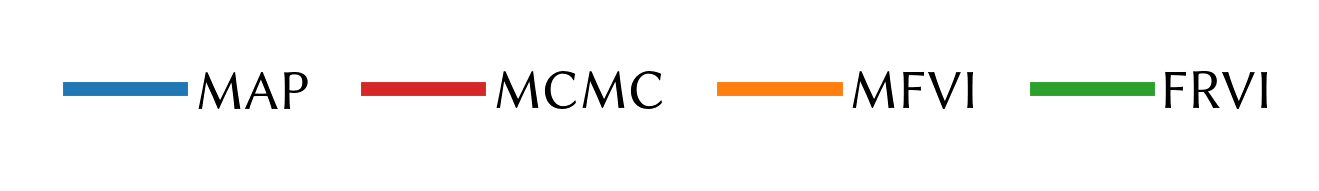

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))

for D in methods.values():
    ax.plot(0, 0, color=D["color"], label=D["papername"])

legend_options = {
    "loc": 3,
    "framealpha": 1,
    "frameon": False,
    "fontsize": 20,
    "handletextpad": 0.3,
    "columnspacing": 1,
    "ncol": 4,
}
legend = ax.legend(**legend_options)

# increase legend line widths
for legobj in legend.legendHandles:
    legobj.set_linewidth(5.0)

ax.axis("off")
plt.savefig("legend.pdf", bbox_inches='tight')
plt.show()

## Performance summary plots

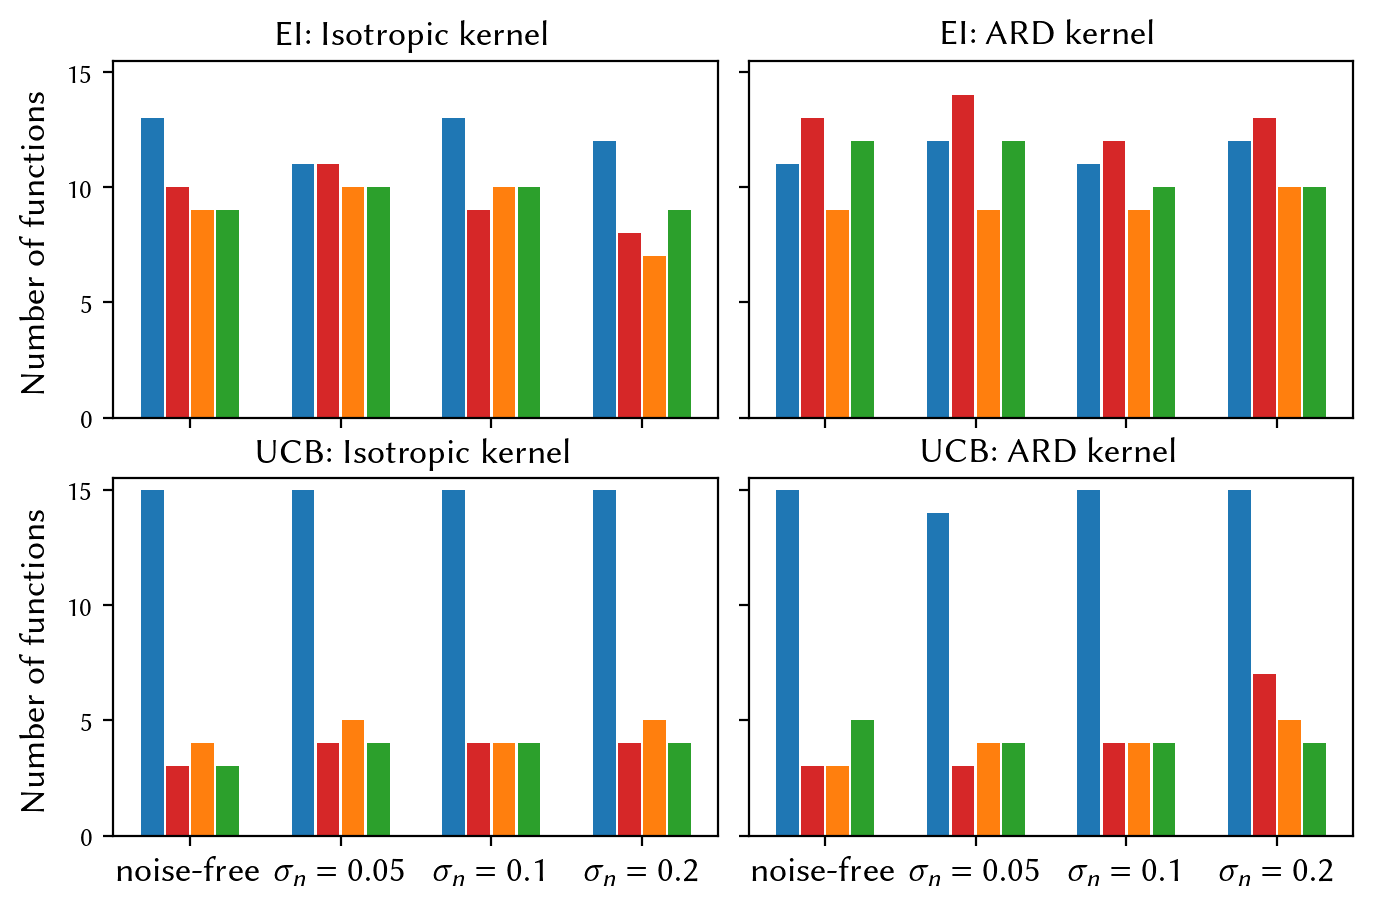

In [261]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)

for i, acq_name in enumerate(acq_funcs):
    for ax, ard, in zip(axes[i, :], use_ard):
        fbbo.results.summary_barchart(
            ax, table_data, acq_name, ard, problem_sets, problems, methods,
        )

        # title
        kern_lbl = "Isotropic" if not ard else "ARD"
        title = f"{acq_funcs[acq_name]:s}: {kern_lbl:s} kernel"
        ax.set_title(title, fontsize=13)

        ax.set_ylim([0, 15.5])

        plt.setp(ax.get_xticklabels(), fontsize=13)


    axes[i, 0].set_ylabel("Number of functions", fontsize=13)
    axes[i, 0].get_yaxis().set_label_coords(-0.1, 0.5)

plt.subplots_adjust(wspace=0.05, hspace=0.17, top=0.9)
plt.savefig(f"acq_comparison.pdf", bbox_inches="tight")
plt.show()

## Comparison of MCMC and MAP only

In [11]:
methods_map_mcmc = {
    "map": {"papername": "MAP", "color": "tab:blue"},
    "mcmc_pm3": {"papername": "MCMC", "color": "tab:red"},
}

# load table data
table_data_map_mcmc = {}

times = [50, 100, 150, -1]

with tqdm.auto.tqdm(
    total=len(problem_sets) * len(use_ard) * len(times)
) as pbar:
    for time in times:
        table_data_map_mcmc[time] = {}

        for problem_set in problem_sets:
            table_data_map_mcmc[time][problem_set] = {}

            for ard in use_ard:
                table_data_map_mcmc[time][problem_set][
                    ard
                ] = fbbo.results.create_table_data(
                    results=results[problem_set],
                    problems=problems,
                    ard=ard,
                    acq_funcs=acq_funcs,
                    methods=methods_map_mcmc,
                    n_runs=n_runs,
                    time=time,
                )
                pbar.update()

  0%|          | 0/32 [00:00<?, ?it/s]

50


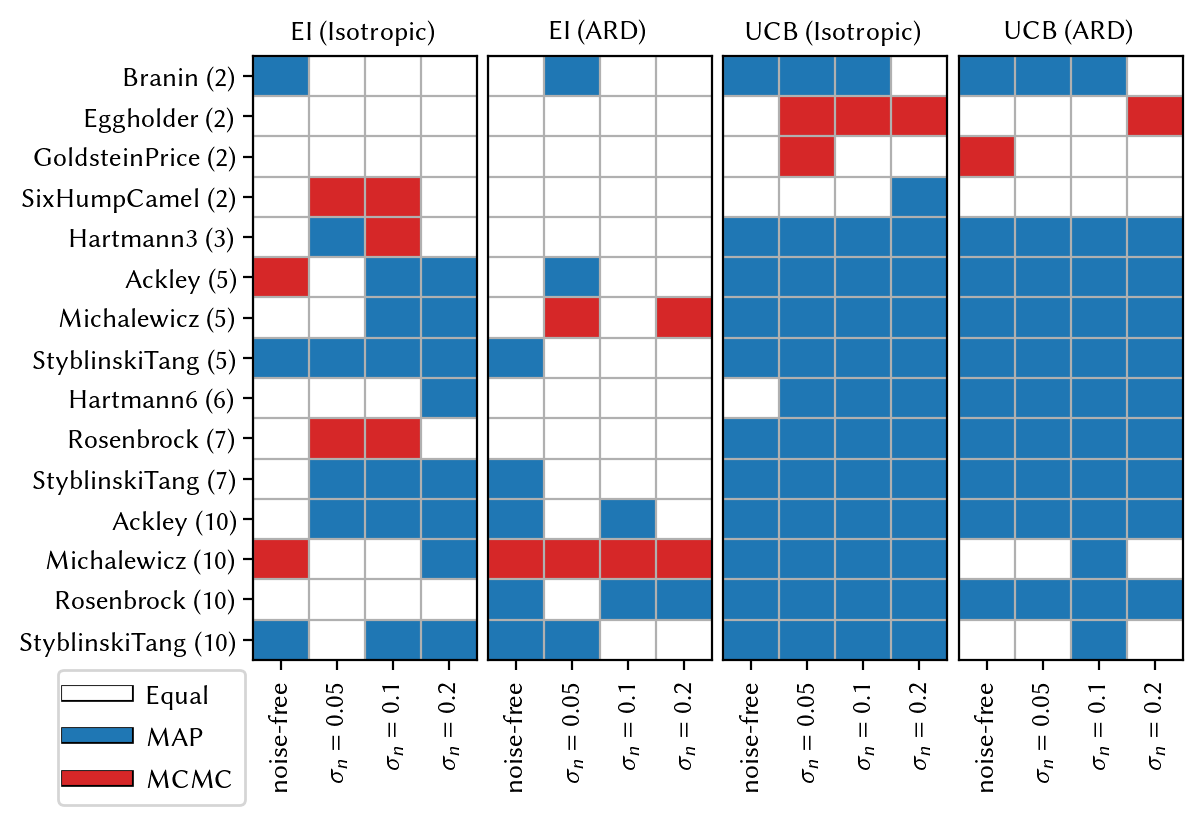

100


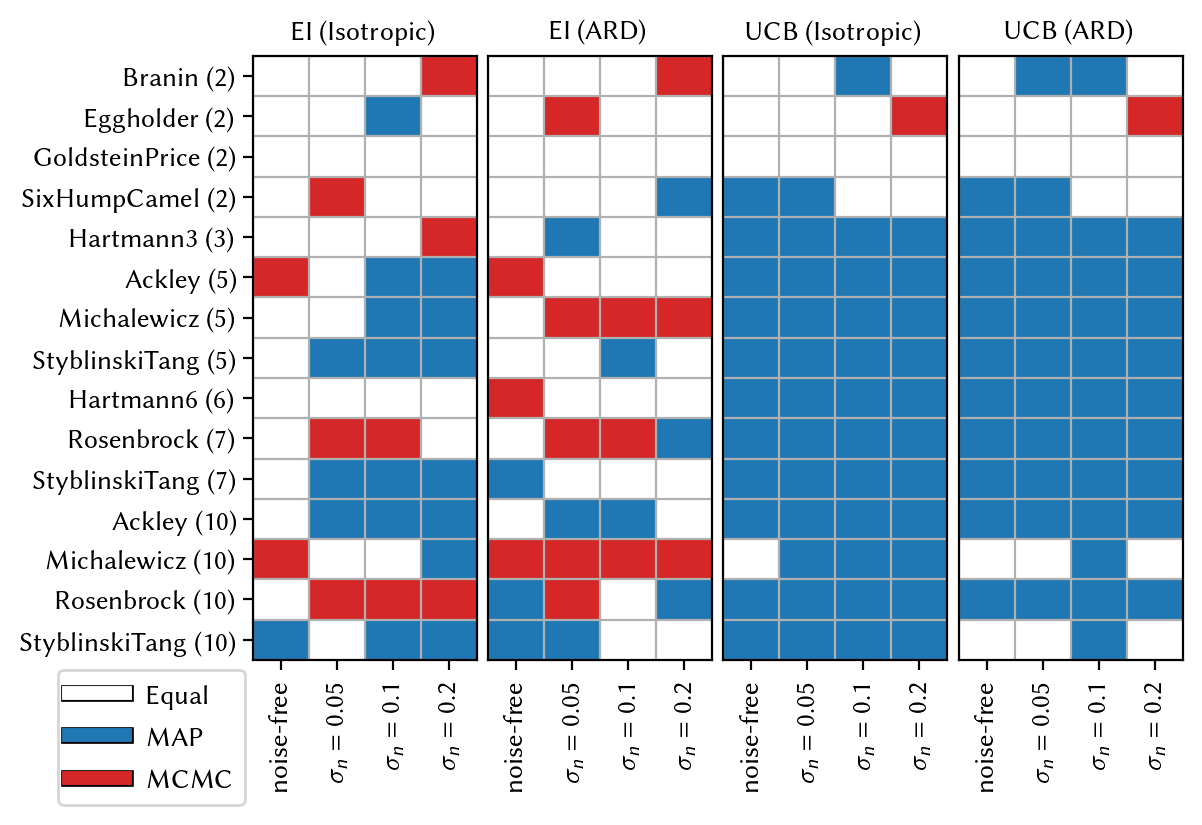

150


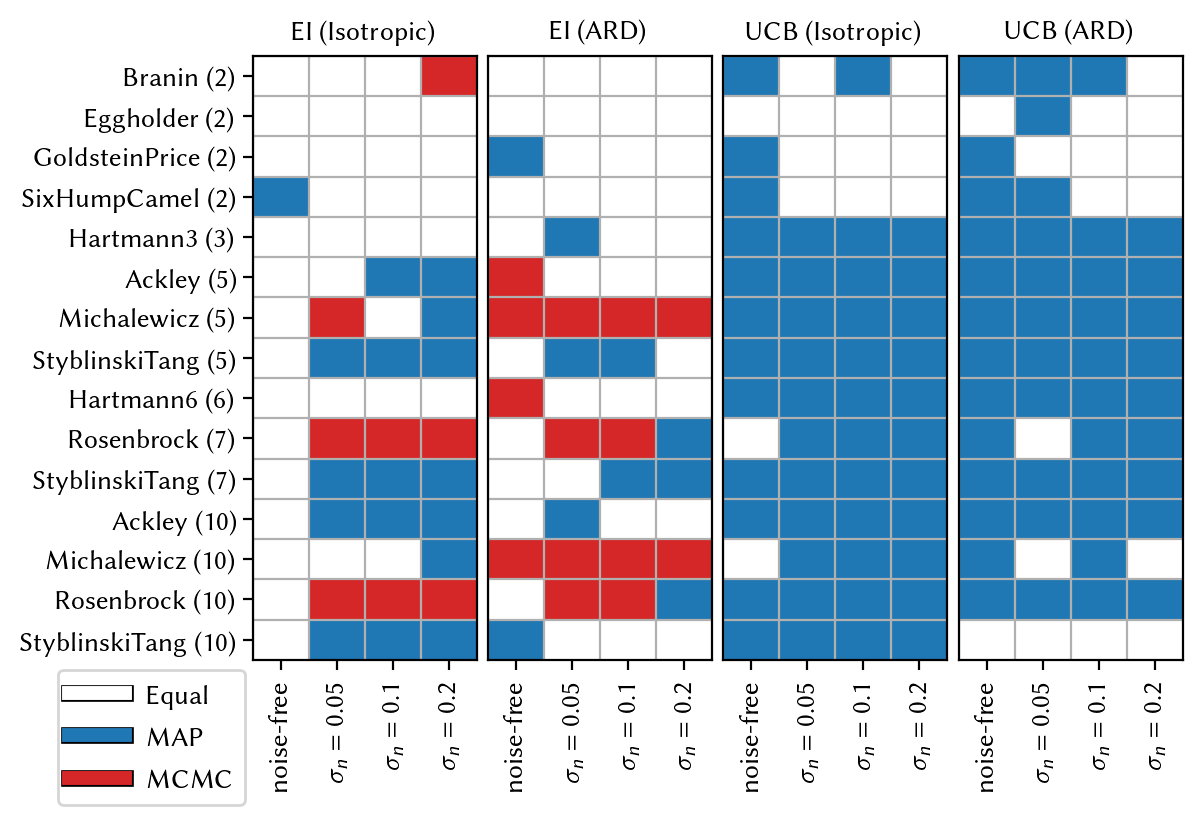

-1


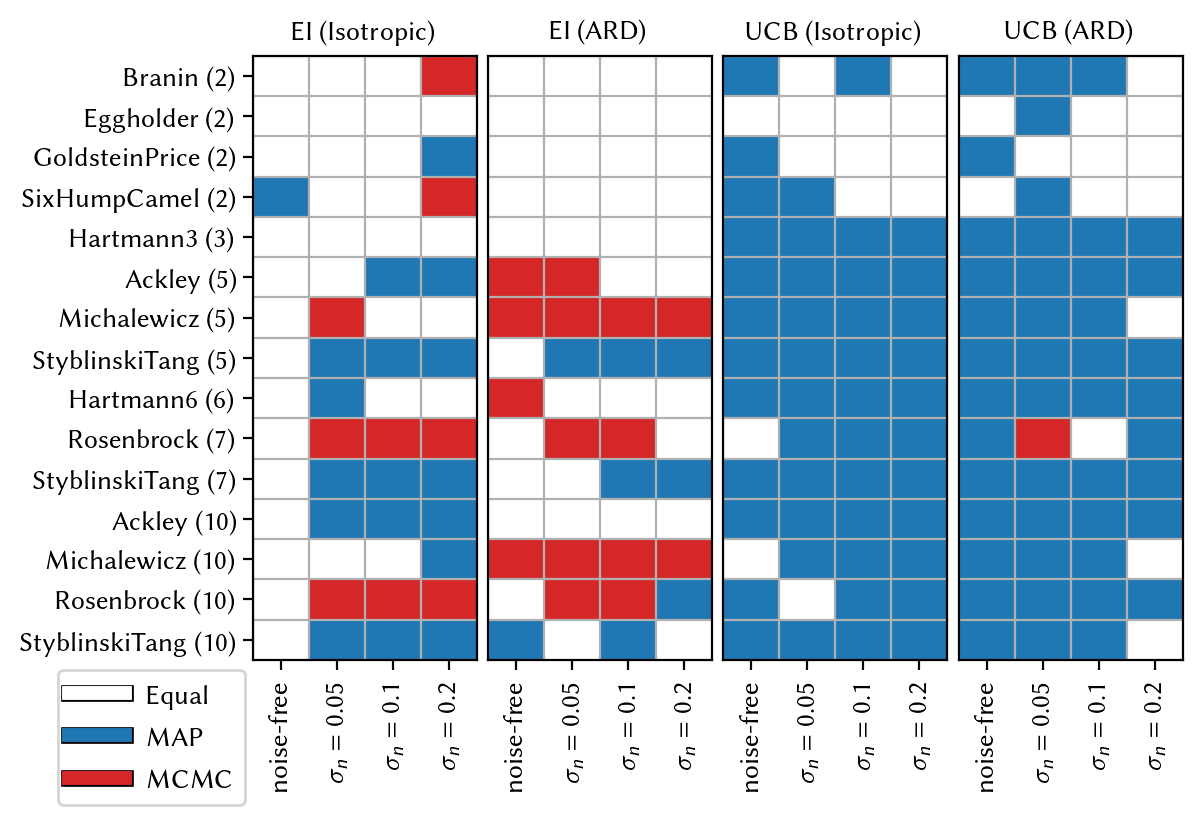

In [19]:
ordered_by_dim_problems = {
    "Branin": {"fname": "Branin", "params": {}},
    "Eggholder": {"fname": "Eggholder", "params": {}},
    "GoldsteinPrice": {"fname": "GoldsteinPrice", "params": {}},
    "SixHumpCamel": {"fname": "SixHumpCamel", "params": {}},
    "Hartmann3": {"fname": "Hartmann3", "params": {}},
    "Ackley5": {"fname": "Ackley", "params": {"d": 5}},
    "Michalewicz5": {"fname": "Michalewicz", "params": {"d": 5}},
    "StyblinskiTang5": {"fname": "StyblinskiTang", "params": {"d": 5}},
    "Hartmann6": {"fname": "Hartmann6", "params": {}},
    "Rosenbrock7": {"fname": "Rosenbrock", "params": {"d": 7}},
    "StyblinskiTang7": {"fname": "StyblinskiTang", "params": {"d": 7}},
    "Ackley10": {"fname": "Ackley", "params": {"d": 10}},
    "Michalewicz10": {"fname": "Michalewicz", "params": {"d": 10}},
    "Rosenbrock10": {"fname": "Rosenbrock", "params": {"d": 10}},
    "StyblinskiTang10": {"fname": "StyblinskiTang", "params": {"d": 10}},
}

for time in times:
    print(time)

    fbbo.results.compare_mcmc_map_plot(
        table_data_map_mcmc[time],
        acq_funcs,
        use_ard,
        problem_sets,
        ordered_by_dim_problems,
        save_fname=f"map_mcmc_squares_plot_t={time}.pdf".replace("-1", "200"),
    )

## Convergence Plots

#### 5 by 3 grid of all 15 problems for each problem set, kernel and acq func combo

In [51]:
problem_names_ordered_for_plotting = [
    "Branin",
    "Eggholder",
    "GoldsteinPrice",
    "SixHumpCamel",
    "Hartmann3",
    "Ackley5",
    "Michalewicz5",
    "StyblinskiTang5",
    "Hartmann6",
    "Rosenbrock7",
    "StyblinskiTang7",
    "Ackley10",
    "Michalewicz10",
    "Rosenbrock10",
    "StyblinskiTang10",
]

c = 0

with tqdm.auto.tqdm(
    total=(len(problem_sets) * len(use_ard) * len(acq_funcs))
) as pbar:

    for problem_set in problem_sets:
        ps_print_name = problem_sets[problem_set]["papername"]

        for ard in use_ard:
            ard_name = "Isotropic" if not ard else "ARD"

            for acq_func in acq_funcs:

                save_name = f"{problem_set}_{ard_name}_{acq_func}.pdf"
                print(save_name)

                fbbo.results.create_gridplot(
                    results=results,
                    problem_set=problem_set,
                    ard=ard,
                    acq_name=acq_func,
                    methods=methods,
                    problems=problems,
                    problem_name_order=problem_names_ordered_for_plotting,
                    budget=budget,
                    savename=save_name,
                    showfig=False,
                    line_width=0.75,
                )
                pbar.update()

  0%|          | 0/16 [00:00<?, ?it/s]

noise-free_Isotropic_ei.pdf
noise-free_Isotropic_ucb.pdf
noise-free_ARD_ei.pdf
noise-free_ARD_ucb.pdf
noise=0.05_Isotropic_ei.pdf
noise=0.05_Isotropic_ucb.pdf
noise=0.05_ARD_ei.pdf
noise=0.05_ARD_ucb.pdf
noise=0.1_Isotropic_ei.pdf
noise=0.1_Isotropic_ucb.pdf
noise=0.1_ARD_ei.pdf
noise=0.1_ARD_ucb.pdf
noise=0.2_Isotropic_ei.pdf
noise=0.2_Isotropic_ucb.pdf
noise=0.2_ARD_ei.pdf
noise=0.2_ARD_ucb.pdf


### a couple of convergence plots for the paper

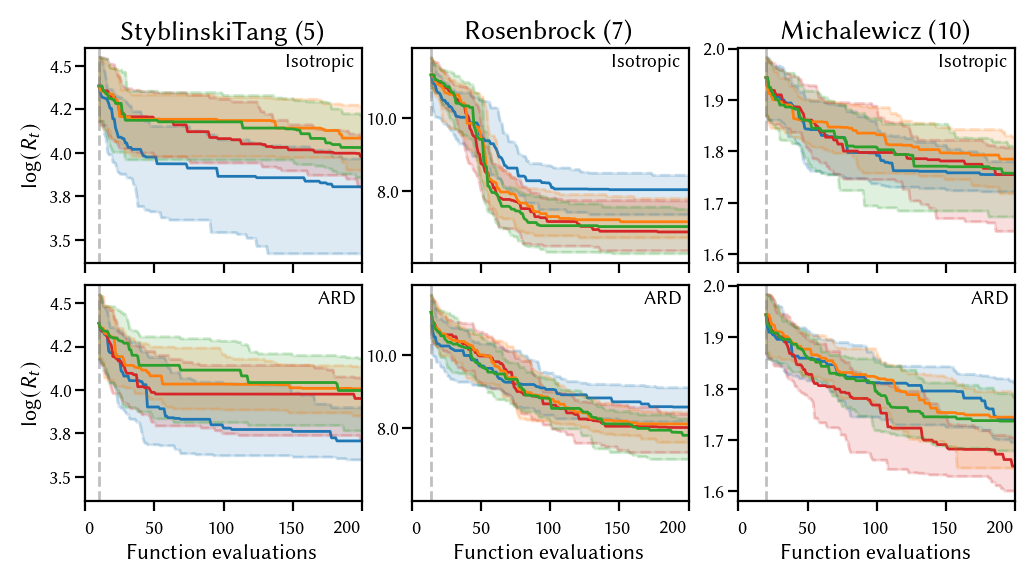

In [52]:
LABEL_FONTSIZE = 8
TITLE_FONTSIZE = 10
TICK_FONTSIZE = 7
line_width = 1

# list of problem_set, acq_name, ard
problem_set = "noise=0.1"
acq_name = "ei"
problem_names_ard = [
    ["StyblinskiTang5", False],
    ["Rosenbrock7", False],
    ["Michalewicz10", False],
    ["StyblinskiTang5", True],
    ["Rosenbrock7", True],
    ["Michalewicz10", True],
]


fig, axes = plt.subplots(2, 3, figsize=(6, 3), sharex=True, sharey="col")

for i, (ax, (pn, ard)) in enumerate(zip(axes.flat, problem_names_ard)):
    f = fbbo.util.test_func_getter(
        problems[pn]["fname"], problems[pn]["params"]
    )
    dim = f.dim

    start = 2 * dim - 1
    end = budget

    x = np.arange(start + 1, end + 1)

    xvals = []
    yvals = []

    for method_name in methods:
        Y = results[problem_set][pn][ard][method_name][acq_name][:, start:end]
        Y = np.log(Y)

        yvals.append(Y)
        xvals.append(x)

    title = f"{problems[pn]['fname']:s} ({dim:d})" if i < 3 else ""

    ylabel = r"$\log(R_t)$" if i % 3 == 0 else ""
    xlabel = "Function evaluations" if i >= 3 else ""

    fbbo.results.results_plot_maker(
        ax,
        yvals,
        xvals,
        xlabel,
        ylabel,
        title,
        [d["color"] for d in methods.values()],
        LABEL_FONTSIZE=LABEL_FONTSIZE,
        TITLE_FONTSIZE=TITLE_FONTSIZE,
        TICK_FONTSIZE=TICK_FONTSIZE,
        use_fill_between=True,
        fix_ticklabels=True,
        method_names=[methods[m]["papername"] for m in methods],
        line_width=line_width,
    )

    ax.get_xaxis().set_label_coords(0.5, -0.2)

    # ensure labels are all in the same place!
    ax.get_yaxis().set_label_coords(-0.16, 0.5)

    # move the title down a bit
    ax.set_title(ax.get_title(), fontsize=TITLE_FONTSIZE, y=0.96)

    for tick in ax.get_yaxis().get_major_ticks():
        tick.set_pad(1.0)

    if ard:
        s = "ARD"
        x=0.84
        y=0.91
        
    else:
        s = "Isotropic"
        x=0.725
        y=0.91
    ax.text(
        x=x,
        y=y,
        s=s,
        transform=ax.transAxes,
        fontsize=7,
        #bbox={"boxstyle": "square", "fc": "w", "ec":"k", "lw":0.8},
    )


plt.subplots_adjust(wspace=0.18, hspace=0.1)
plt.savefig('paper_conv_plot.pdf')
plt.show()

## uncertainty comparison between MAP and MCMC

In [20]:
# load the data
with np.load("MAP_plot.npz", allow_pickle=True) as d:
    map_plot = d["map_plot"].item()
    
mcmc_plot = torch.load("MCMC_plot.pt")

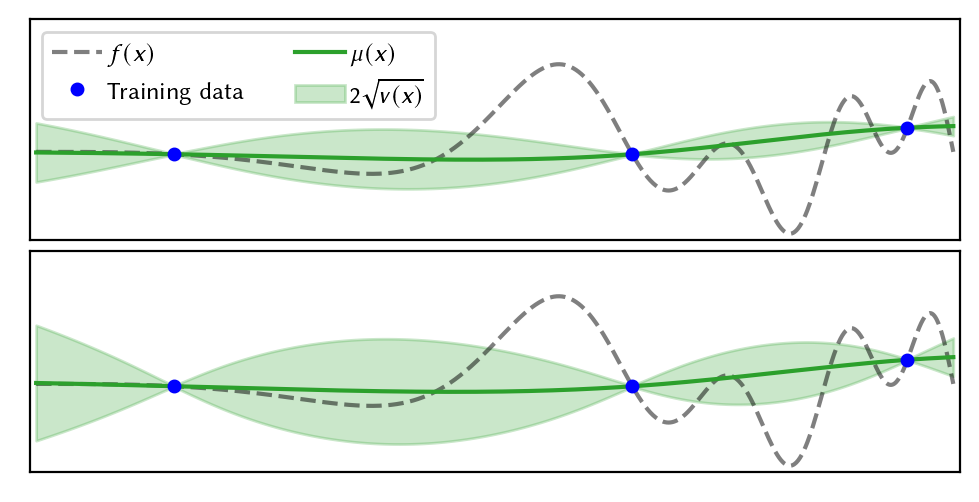

In [21]:
# what timestep to plot
t = 0

# assume it will be a column-based plot
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True, sharey=True)

for i, (D, ax) in enumerate(zip([map_plot, mcmc_plot], axes)):
    # real function
    x = D["X"].numpy().ravel()
    fx = D["fX"].numpy().ravel()

    # training data
    Xtr = D["Xtr"][t].numpy().ravel()
    Ytr = D["Ytr"][t].numpy().ravel()

    # gp predictions
    mu = D["mu"][t]
    lower = D["lower"][t]
    upper = D["upper"][t]

    if mu.ndim == 2:
        mu = np.mean(mu, axis=0)
        lower = np.mean(lower, axis=0)
        upper = np.mean(upper, axis=0)

    # plot the data
    l_f = ax.plot(x, fx, color="k", ls="--", alpha=0.5, label="$f(x)$")
    l_unc = ax.fill_between(
        x, lower, upper, color="tab:green", alpha=0.25, label="$2 \sqrt{v(x)}$"
    )
    l_mu = ax.plot(x, mu, color="tab:green", label="$\mu(x)$")

    l_tr = ax.plot(Xtr, Ytr, "bo", ms=4, label="Training data")

    # tidy up the figure
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim([-0.007, 1.007])
    ax.set_ylim([-2, 3])

    if i == 0:
        ax.legend(
            handles=[l_f[0], l_tr[0], l_mu[0], l_unc],
            loc="upper left",
            ncol=2,
            fontsize=9,
            handletextpad=0.2,
        )
plt.subplots_adjust(hspace=0.05)
plt.savefig("map_mcmc_comparison.pdf", bbox_inches="tight", transparent=True)
plt.show()

## determine which method combination is better (acq + kernel) for each noise setting

In [77]:
import warnings
from scipy.stats import median_abs_deviation, wilcoxon
from statsmodels.stats.multitest import multipletests


compared_inf_methods = ["mcmc_pm3", "map"]
compared_acq_funcs = ["ei", "ucb"]
compared_ard = [False, True]
time = -1

# create a list of the method names for plotting or whatever
method_list = []
method_names = []

for ard in compared_ard:
    for m in compared_inf_methods:
        for acq in compared_acq_funcs:
            name = f"{acq_funcs[acq]} - {methods[m]['papername']}"
            name += f" - " + ("Isotropic" if not ard else "ARD")
            method_names.append(name)

            method_list.append((acq, m, ard))


n_methods = len(method_names)

counts = []

for k, problem_set in enumerate(problem_sets):
    best_method_counts = np.zeros((n_methods,))

    for pn in problems:
        best_seen_values = np.zeros((n_methods, n_runs))

        i = 0
        for (acq, m, ard) in method_list:
            best_seen_values[i, :] = results[problem_set][pn][ard][m][acq][
                :, time
            ]
            i += 1

        medians = np.median(best_seen_values, axis=1)
        MADS = median_abs_deviation(best_seen_values, scale="normal", axis=1)

        # best method -> lowest median value
        best_method_idx = np.argmin(medians)

        # print(pn, method_names[best_method_idx])

        # mask of methods equivlent to the best
        # if there are others that are equal, also mark them as best
        # because this isn't dealt with in the logic below
        stats_equal_to_best_mask = medians == np.min(medians)

        # perform wilcoxon signed rank test between best and all other methods
        p_values = []
        for i, method_name in enumerate(method_names):
            if i == best_method_idx:
                continue
            # a ValueError will be thrown if the runs are all identical,
            # therefore we can assign a p-value of 0 as they are identical
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    _, p_value = wilcoxon(
                        best_seen_values[best_method_idx, :],
                        best_seen_values[i, :],
                    )
                p_values.append(p_value)

            except ValueError:
                p_values.append(0)

        # calculate the Holm-Bonferroni correction
        reject_hyp, pvals_corrected, _, _ = multipletests(
            p_values, alpha=0.05, method="holm"
        )

        for reject, method_name in zip(
            reject_hyp,
            [m for m in method_names if m != method_names[best_method_idx]],
        ):
            # if we can't reject the hypothesis that a technique is
            # statistically equivalent to the best method
            if not reject:
                idx = np.where(np.array(method_names) == method_name)[0][0]
                stats_equal_to_best_mask[idx] = True

        best_method_counts += stats_equal_to_best_mask
        
    counts.append(best_method_counts)

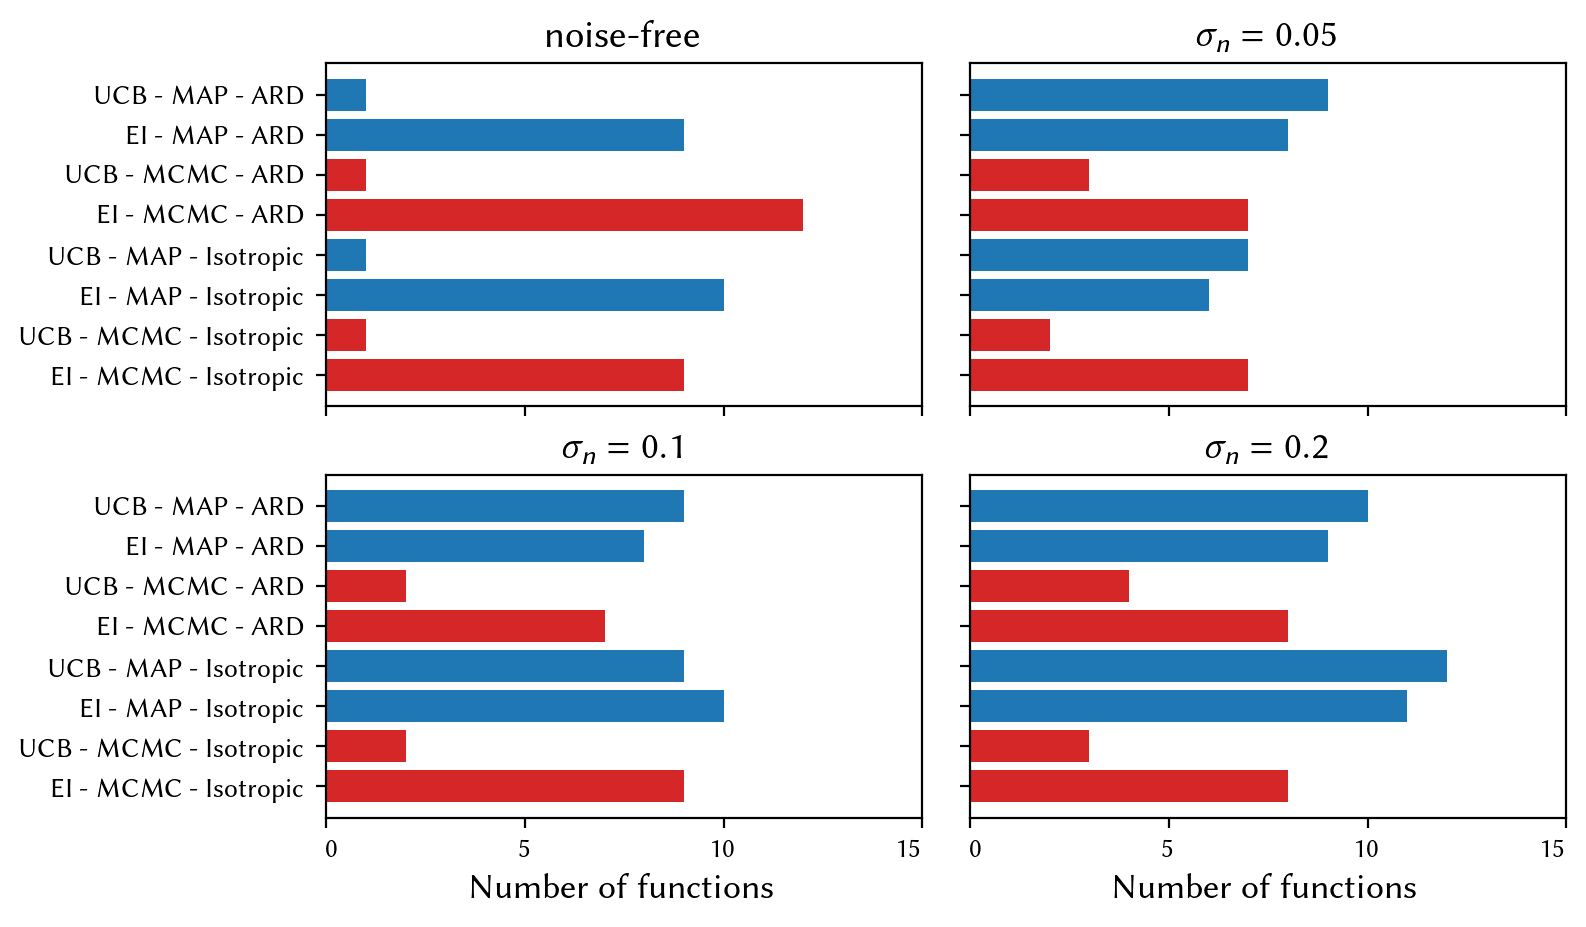

In [100]:
colors = ["tab:red", "tab:red", "tab:blue", "tab:blue"] * 2

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)

for i, (ax, c, problem_set) in enumerate(zip(axes.flat, counts, problem_sets)):
    best_method_counts = np.zeros((n_methods,))

    ax.barh(y=range(n_methods), width=c, color=colors)
    ax.set_title(problem_sets[problem_set]["papername"], fontsize=14)

    if i >= 2:
        ax.set_xticks([0, 5, 10, 15])
        ax.set_yticks(range(n_methods))
        ax.set_yticklabels(method_names)
        
        ticklabels = ax.get_xticklabels()
        if len(ticklabels) > 0:
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

        ax.set_xlabel("Number of functions", fontsize=13)

ax.set_xlim([0, 15])
plt.subplots_adjust(wspace=0.08)
plt.savefig(f"method_rankings_per_noise.pdf", bbox_inches="tight")
plt.show()

## calculate the distances between consecutive evaluated locations so we can see if MCMC provides more exploration for EI/egreedy/ucb -- we assume it does.

In [24]:
normalise_distances = True

distances = {}

for problem_set in tqdm.auto.tqdm(problem_sets):

    distances[problem_set] = fbbo.results.load_distances(
        problems=problems,
        methods=methods,
        acq_funcs=acq_funcs,
        n_runs=n_runs,
        budget=budget,
        use_ard=use_ard,
        noise_level=problem_sets[problem_set]["noise_level"],
        normalise_distances=normalise_distances,
    )

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/12240 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

distances_noise-free_Isotropic_ei.pdf


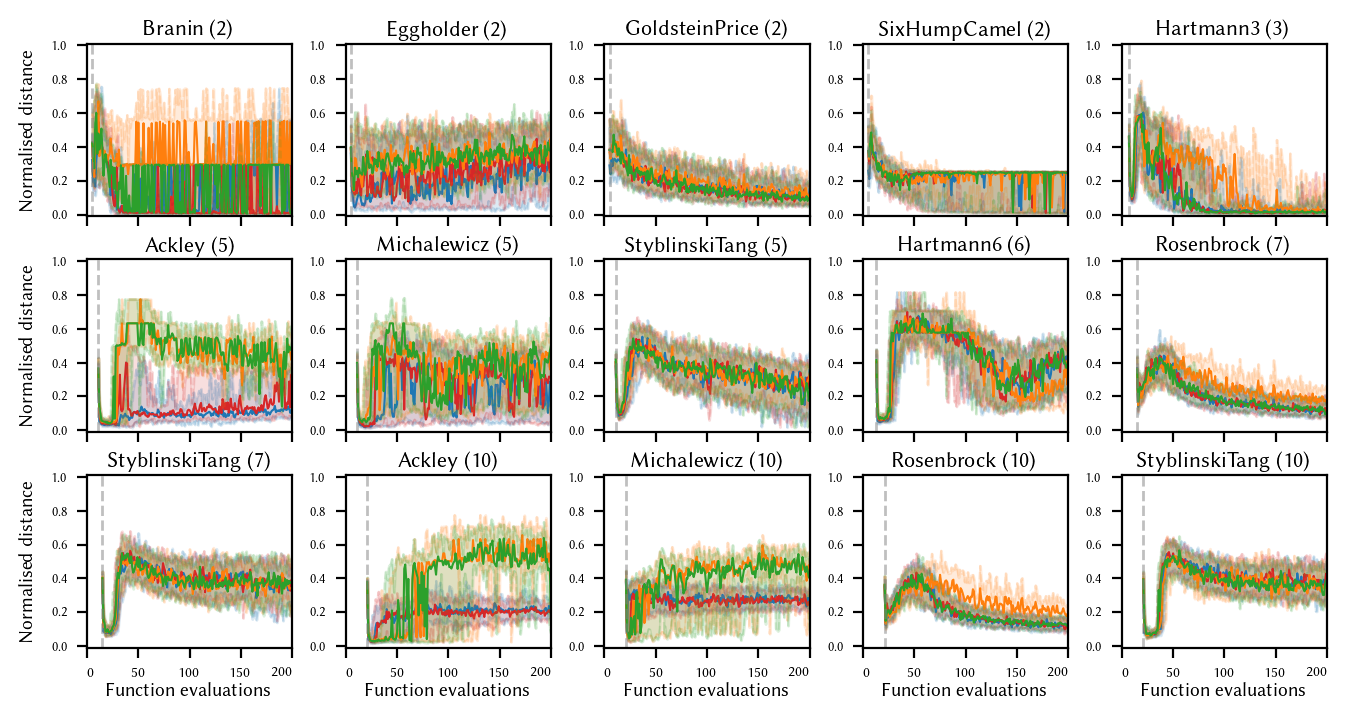

distances_noise=0.05_Isotropic_ei.pdf


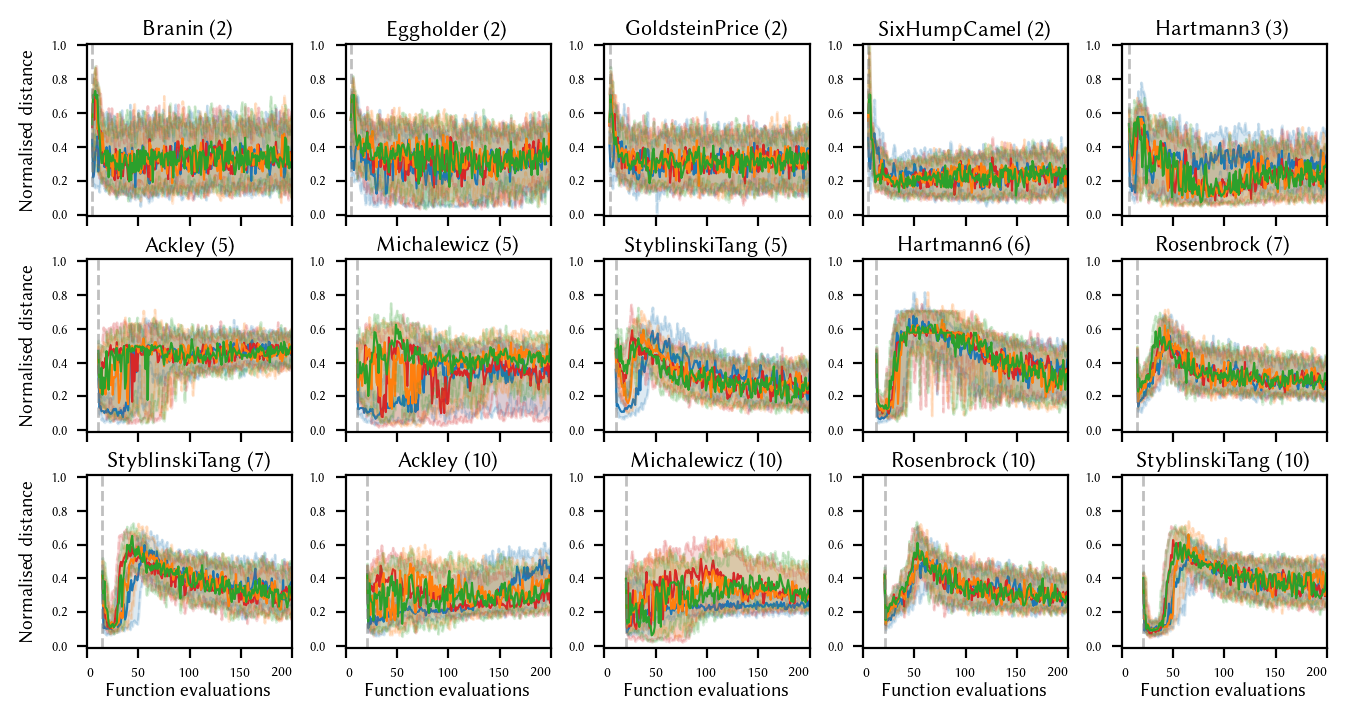

distances_noise=0.1_Isotropic_ei.pdf


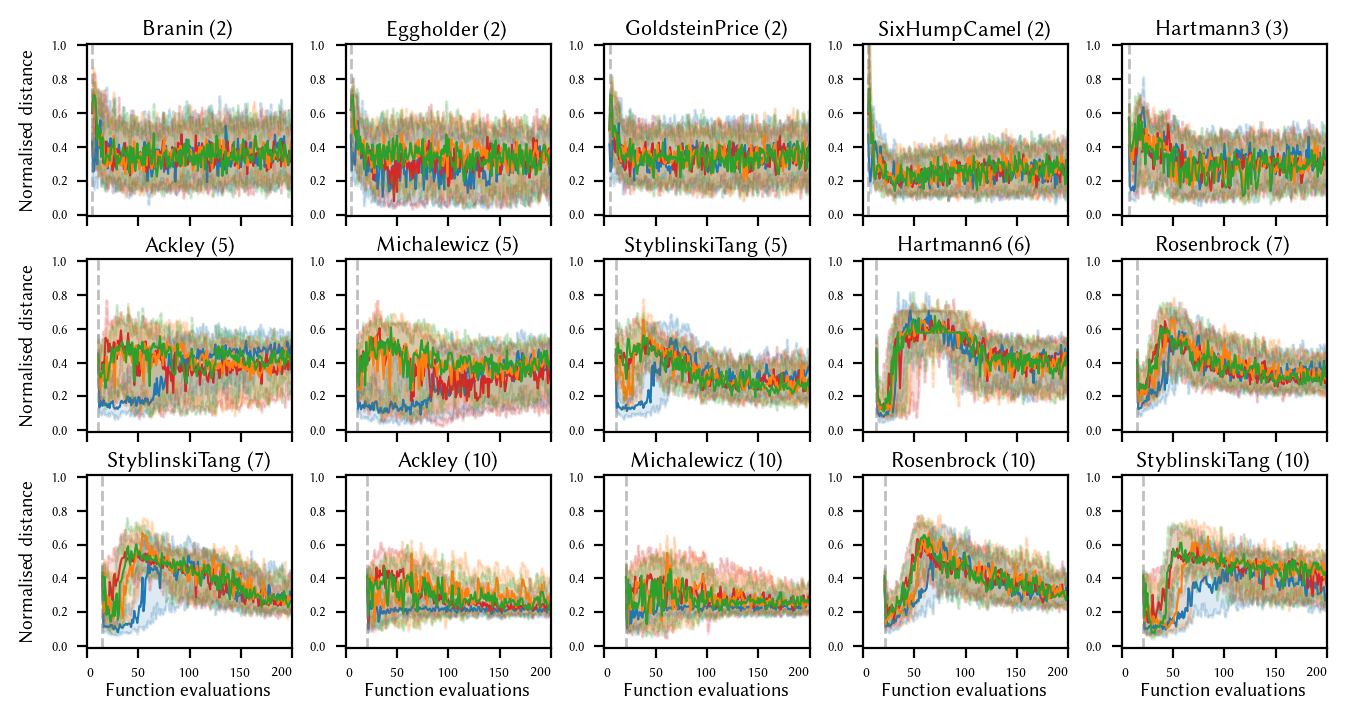

distances_noise=0.2_Isotropic_ei.pdf


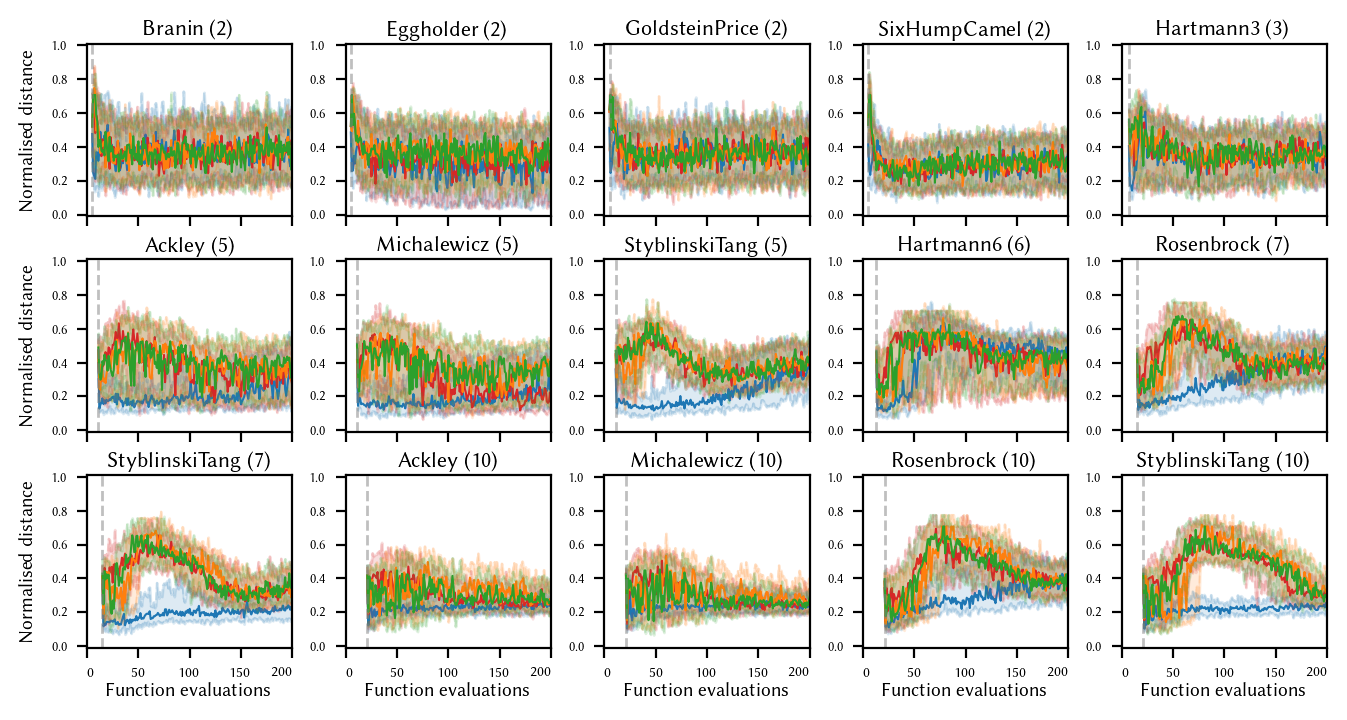

distances_noise-free_ARD_ei.pdf


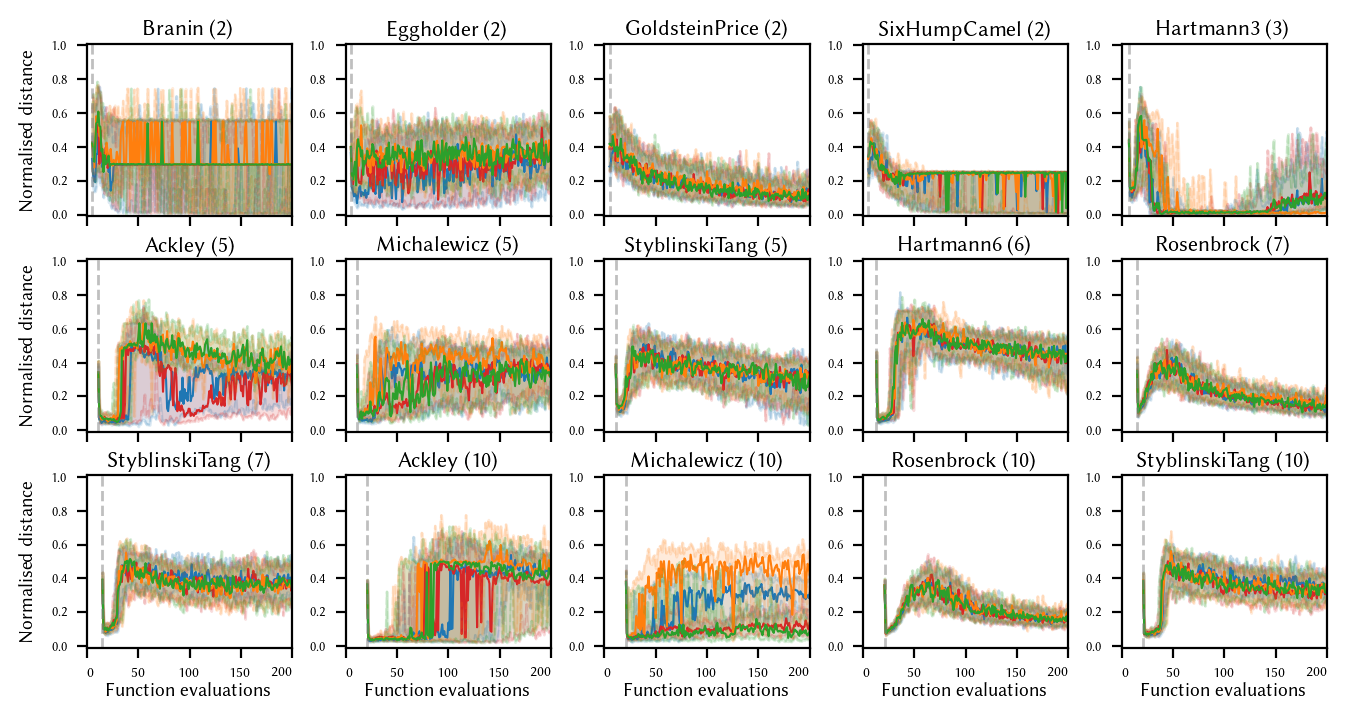

distances_noise=0.05_ARD_ei.pdf


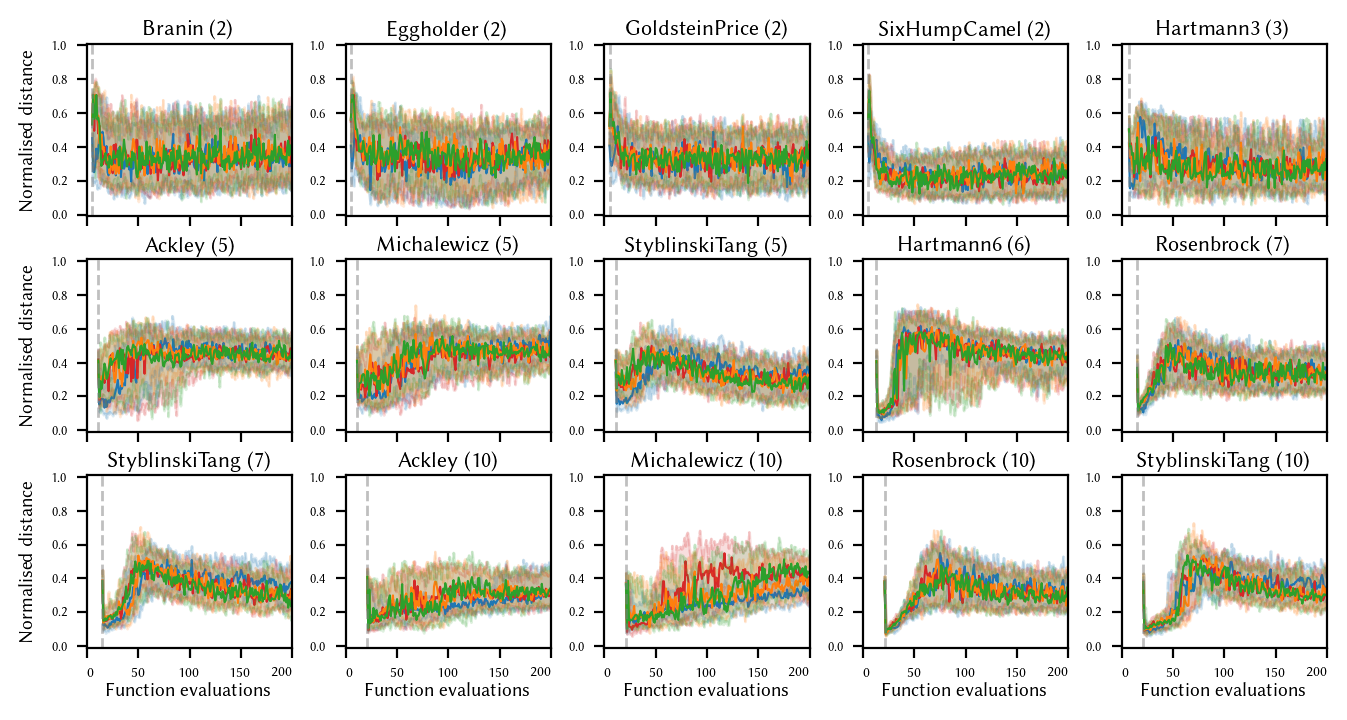

distances_noise=0.1_ARD_ei.pdf


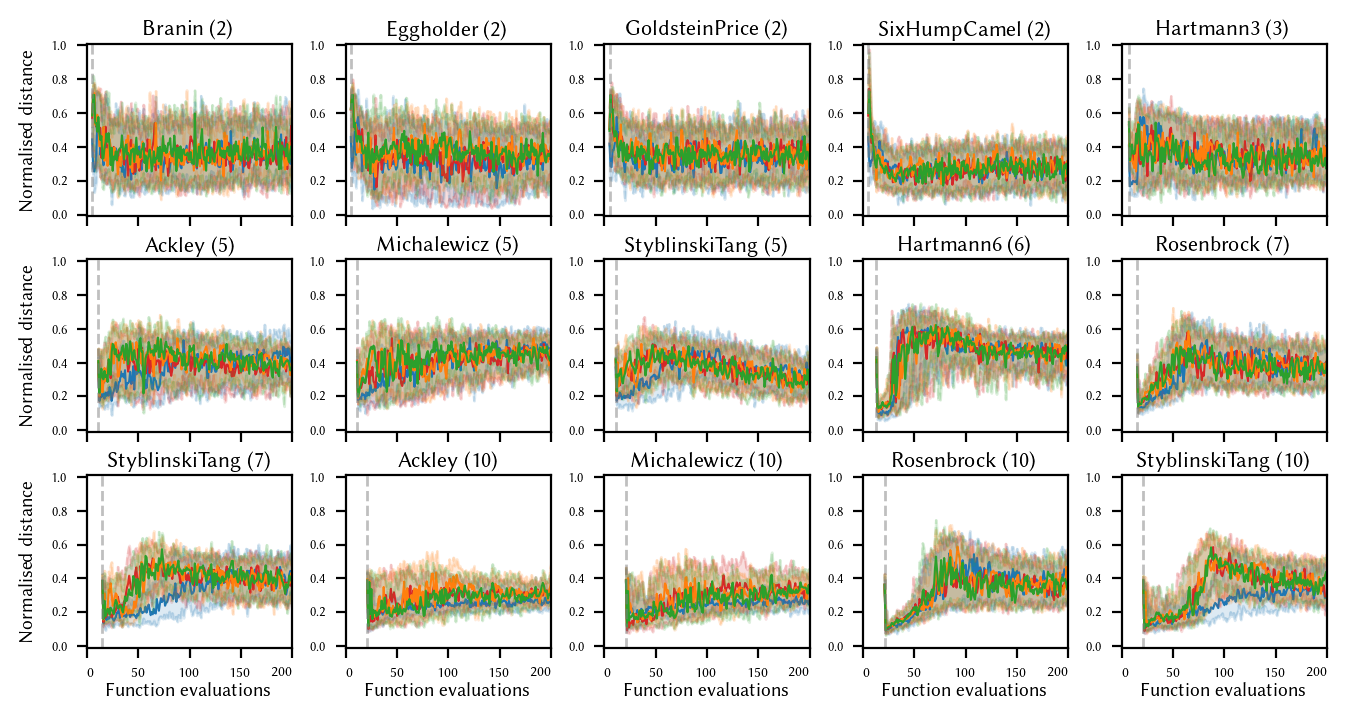

distances_noise=0.2_ARD_ei.pdf


KeyboardInterrupt: 

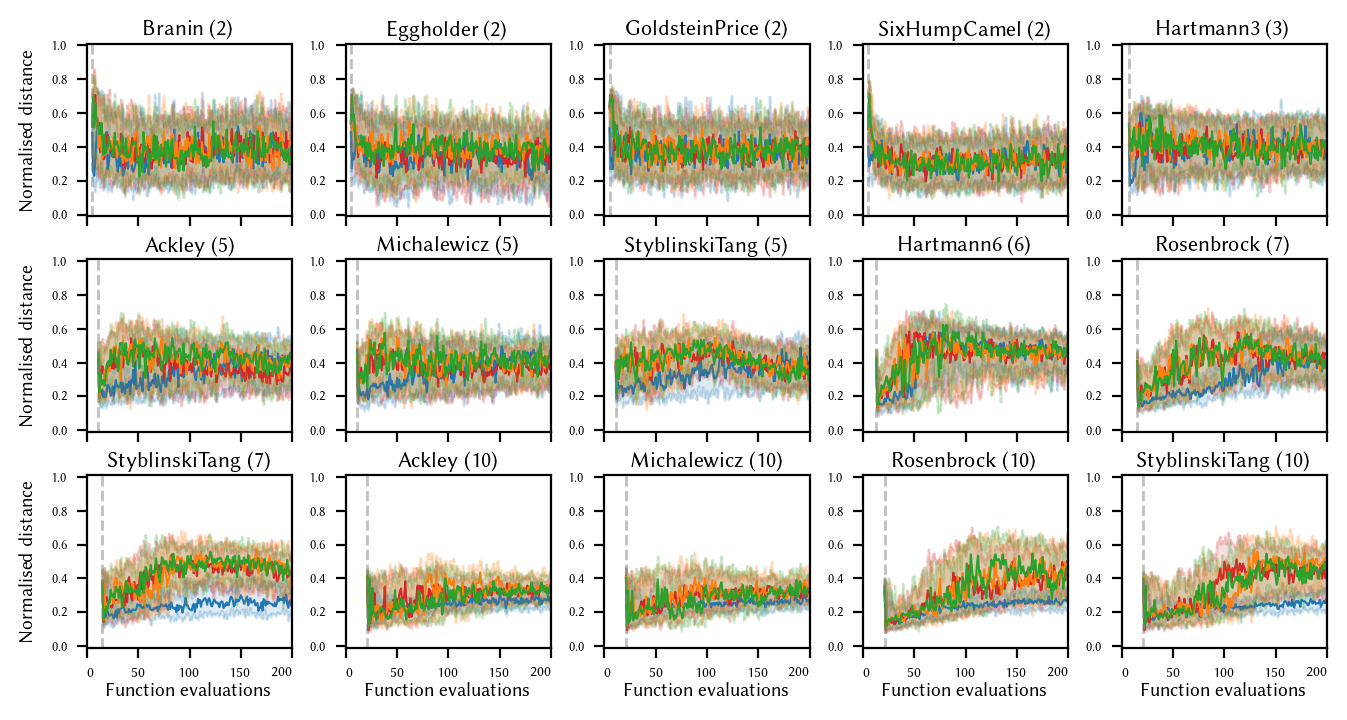

In [234]:
problem_names_ordered_for_plotting = [
    "Branin",
    "Eggholder",
    "GoldsteinPrice",
    "SixHumpCamel",
    "Hartmann3",
    "Ackley5",
    "Michalewicz5",
    "StyblinskiTang5",
    "Hartmann6",
    "Rosenbrock7",
    "StyblinskiTang7",
    "Ackley10",
    "Michalewicz10",
    "Rosenbrock10",
    "StyblinskiTang10",
]

c = 0

with tqdm.auto.tqdm(
    total=(len(problem_sets) * len(use_ard) * len(acq_funcs))
) as pbar:

    for acq_func in acq_funcs:
        for ard in use_ard:
            ard_name = "Isotropic" if not ard else "ARD"

            for problem_set in problem_sets:
                ps_print_name = problem_sets[problem_set]["papername"]

                save_name = (
                    f"distances_{problem_set}_{ard_name}_{acq_func}.pdf"
                )
                print(save_name)

                fbbo.results.create_distance_gridplot(
                    results=distances,
                    problem_set=problem_set,
                    ard=ard,
                    acq_name=acq_func,
                    methods=methods,
                    problems=problems,
                    problem_name_order=problem_names_ordered_for_plotting,
                    budget=budget,
                    savename=save_name,
                    showfig=True,
                    line_width=0.75,
                    normalise_distances=normalise_distances,
                )
                pbar.update()